In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import SparsePCA

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

class MoannaDataset(Dataset):
    def __init__(self, data_file, label_file, n_components=500):
        self.data = pd.read_csv(data_file, sep=',', header=0, index_col=0).values
        self.label = pd.read_csv(label_file, header=0, index_col=0).values[:,1]
        
        # Use variance threshold to select features
        # selector = VarianceThreshold(threshold=var_threshold)
        # self.data = selector.fit_transform(self.data)
        
        # Use PCA to reduce the number of features
        # pca = PCA(n_components=n_components)
        # self.data = pca.fit_transform(self.data)
        
        # Use Sparse PCA to reduce the number of features
        spca = SparsePCA(n_components=n_components)
        self.data = spca.fit_transform(self.data)
        
        self.data = torch.from_numpy(self.data).float().to(device)
        self.label = self.label.astype(int)
        self.label = torch.from_numpy(self.label).long().to(device)

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


In [106]:

data_file = '/home/intern/WarmUpProject/p-tcga_binary_mutation.csv'
label_file = '/home/intern/WarmUpProject/pp-TCGA-clinical.csv'

dataset = MoannaDataset(data_file, label_file)

KeyboardInterrupt: 

In [ ]:
batch_size = 256


In [ ]:
idx = torch.randperm(len(dataset))

split_point = int(0.7 * len(idx))

train_idx = list(idx[:split_point])
test_idx = list(idx[split_point:])

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 


In [ ]:
len(train_dataset)

7028

In [ ]:
train_dataset[7000][0]

tensor([ 1.5774, -1.5362, -0.8292, -0.1962, -0.0307, -0.0799,  1.0026,  0.3972,
         0.0265, -0.1900, -0.2261,  0.0070, -0.1681, -0.2100,  0.1456, -0.2873,
        -0.0631, -0.2383, -0.0434,  0.1374, -0.0667, -0.0924,  0.0576,  0.2267,
        -0.0817, -0.0371, -0.1763, -0.1175, -0.0472,  0.2944,  0.1797,  0.0432,
         0.0557,  0.1162, -0.0256, -0.1339, -0.0628, -0.0957, -0.2400, -0.0206,
         0.0953,  0.0955, -0.1862, -0.1780, -0.1120,  0.0264, -0.2347,  0.0746,
        -0.1843, -0.1724, -0.1823,  0.0714, -0.2220,  0.3265, -0.2704, -0.2280,
        -0.0609, -0.1205, -0.4110,  0.3222, -0.2742, -0.0537,  0.1143,  0.1610,
        -0.1083, -0.0176, -0.0041,  0.0060, -0.4773, -0.3896, -0.3012,  0.0259,
        -0.0283, -0.1396, -0.1469, -0.2429, -0.2982, -0.3624, -0.6604,  0.1643,
        -0.0290, -0.2780,  0.2889, -0.0856, -0.0991, -0.0242, -0.5785, -0.0028,
        -0.0752, -0.0445, -0.1680,  0.0064,  0.0195, -0.5078, -0.2763,  0.1050,
         0.2114,  0.2529,  0.1286, -0.02

In [ ]:
len(train_dataset[0][0])

500

In [ ]:
class MoannaModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0):
        super(MoannaModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        # self.t = nn.Tanh()
        self.dropout = nn.Dropout(dropout)
        # self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # self.relu1 = nn.ReLU()
        # self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        # out = self.batchnorm(out)
        out = self.relu(out)
        # out = self.t(out)
        out = self.dropout(out)
        # out = self.fc3(out)
        # out = self.relu1(out)
        # out = self.dropout1(out)
        out = self.fc2(out)
        return out

In [ ]:
def k_fold_cross_validation(train_dataset, test_loader, k, num_epochs, batch_size, learning_rate, hidden_dim, device, shuffle=True):
    
    n_samples = len(train_dataset)
    fold_size = n_samples // k
    indices = np.random.permutation(n_samples)

    Model = []
    Train_acc = []
    Val_acc = []
    Test_acc = []
    
    for i in range(k):
        print(f"Processing fold {i+1}/{k}...")
        
        start = i * fold_size
        end = (i + 1) * fold_size
        
        traintrain_indices = list(np.concatenate([indices[:start], indices[end:]]))
        trainval_indices = list(indices[start:end])
        
        # Create data loaders for training and validation
        traintrain_dataset = Subset(train_dataset, traintrain_indices)
        trainval_dataset = Subset(train_dataset, trainval_indices)
        traintrain_loader = DataLoader(traintrain_dataset, batch_size=batch_size, shuffle=shuffle)
        trainval_loader = DataLoader(trainval_dataset, batch_size=batch_size, shuffle=False)    
        
        # Hyperparameters
        # learning_rate = 0.1
        # hidden_dim = 512

        # Initialize model and transfer to GPU
        model = MoannaModel(len(train_dataset[0][0]), hidden_dim, 33).to(device)
        

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        
        # Train the model
        train_losses = []
        train_accs = []
        val_accs = []
        test_accs = []
        
        for epoch in range(num_epochs):
            # Train
            model.train()
            train_loss = 0.0
            train_acc = 0.0
            for j, (inputs, labels) in enumerate(traintrain_loader):
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())

            train_loss /= len(traintrain_loader)
            train_acc /= len(traintrain_loader)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            # Validate
            model.eval()
            val_acc = 0.0
            with torch.no_grad():
                for inputs, labels in trainval_loader:
                    outputs = model(inputs)
                    val_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())
                val_acc /= len(trainval_loader)
                val_accs.append(val_acc)

            # # Check if this is the best model so far
            # if val_acc > best_accuracy:
            #     best_accuracy = val_acc
            #     best_model = model.__class__(train_dataset.data.shape[1], hidden_dim, 33).to(device)
            #     best_model.load_state_dict(model.state_dict())
                
            # Test
            model.eval()
            test_acc = 0.0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    test_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())
                test_acc /= len(test_loader)
                test_accs.append(test_acc)
                
            print(f"Fold {i+1}/{k}, Epoch {epoch+1}: Train Loss={train_loss:.4f}, "
                  f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Test Acc={test_acc:.4f}")
            
        MModel = model.__class__(len(train_dataset[0][0]), hidden_dim, 33).to(device)
        MModel.load_state_dict(model.state_dict())
        Model.append(MModel)
        
        Train_acc.append(train_accs[-1])
        Val_acc.append(val_accs[-1])
        Test_acc.append(test_accs[-1])
        
        # Plot loss and accuracy for this fold
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.legend()
        plt.title(f"Fold {i+1} Loss")

        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Acc')
        plt.plot(val_accs, label='Val Acc')
        plt.plot(test_accs, label='Test Acc')
        plt.legend()
        plt.title(f"Fold {i+1} Accuracy")
        plt.show()

    return Model, Train_acc, Val_acc, Test_acc

Processing fold 1/5...
Fold 1/5, Epoch 1: Train Loss=3.4174, Train Acc=0.1134, Val Acc=0.1472, Test Acc=0.1335
Fold 1/5, Epoch 2: Train Loss=3.3042, Train Acc=0.1464, Val Acc=0.1531, Test Acc=0.1454
Fold 1/5, Epoch 3: Train Loss=3.2245, Train Acc=0.1568, Val Acc=0.1583, Test Acc=0.1536
Fold 1/5, Epoch 4: Train Loss=3.1574, Train Acc=0.1687, Val Acc=0.1635, Test Acc=0.1616
Fold 1/5, Epoch 5: Train Loss=3.0990, Train Acc=0.1762, Val Acc=0.1668, Test Acc=0.1665
Fold 1/5, Epoch 6: Train Loss=3.0473, Train Acc=0.1842, Val Acc=0.1707, Test Acc=0.1695
Fold 1/5, Epoch 7: Train Loss=2.9996, Train Acc=0.1924, Val Acc=0.1845, Test Acc=0.1763
Fold 1/5, Epoch 8: Train Loss=2.9545, Train Acc=0.2009, Val Acc=0.1957, Test Acc=0.1851
Fold 1/5, Epoch 9: Train Loss=2.9106, Train Acc=0.2124, Val Acc=0.2126, Test Acc=0.2022
Fold 1/5, Epoch 10: Train Loss=2.8678, Train Acc=0.2386, Val Acc=0.2270, Test Acc=0.2139
Fold 1/5, Epoch 11: Train Loss=2.8260, Train Acc=0.2520, Val Acc=0.2395, Test Acc=0.2240
Fold 1/

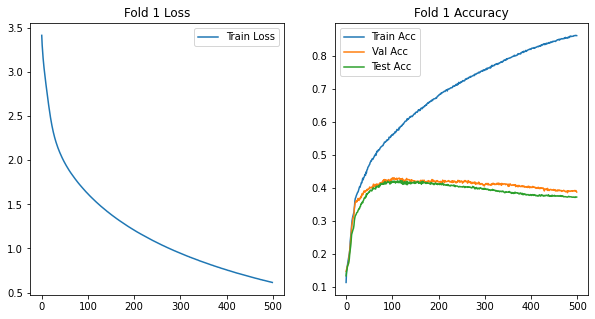

Processing fold 2/5...
Fold 2/5, Epoch 1: Train Loss=3.4147, Train Acc=0.1098, Val Acc=0.1280, Test Acc=0.1277
Fold 2/5, Epoch 2: Train Loss=3.3060, Train Acc=0.1459, Val Acc=0.1398, Test Acc=0.1409
Fold 2/5, Epoch 3: Train Loss=3.2295, Train Acc=0.1547, Val Acc=0.1483, Test Acc=0.1452
Fold 2/5, Epoch 4: Train Loss=3.1647, Train Acc=0.1626, Val Acc=0.1548, Test Acc=0.1534
Fold 2/5, Epoch 5: Train Loss=3.1073, Train Acc=0.1718, Val Acc=0.1614, Test Acc=0.1612
Fold 2/5, Epoch 6: Train Loss=3.0556, Train Acc=0.1808, Val Acc=0.1639, Test Acc=0.1669
Fold 2/5, Epoch 7: Train Loss=3.0082, Train Acc=0.1903, Val Acc=0.1771, Test Acc=0.1763
Fold 2/5, Epoch 8: Train Loss=2.9631, Train Acc=0.2008, Val Acc=0.1902, Test Acc=0.1852
Fold 2/5, Epoch 9: Train Loss=2.9196, Train Acc=0.2160, Val Acc=0.2052, Test Acc=0.2025
Fold 2/5, Epoch 10: Train Loss=2.8772, Train Acc=0.2349, Val Acc=0.2176, Test Acc=0.2187
Fold 2/5, Epoch 11: Train Loss=2.8350, Train Acc=0.2532, Val Acc=0.2333, Test Acc=0.2311
Fold 2/

KeyboardInterrupt: 

In [ ]:
num_epochs = 500
k = 5
learning_rate = 0.1
hidden_dim = 1024

Model, Train_acc, Val_acc, Test_acc = k_fold_cross_validation(train_dataset, test_loader, k, num_epochs, batch_size, learning_rate, hidden_dim, device=device, shuffle=True)

In [ ]:
Model

[MoannaModel(
   (fc1): Linear(in_features=1000, out_features=1024, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0, inplace=False)
   (fc2): Linear(in_features=1024, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=1000, out_features=1024, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0, inplace=False)
   (fc2): Linear(in_features=1024, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=1000, out_features=1024, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0, inplace=False)
   (fc2): Linear(in_features=1024, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=1000, out_features=1024, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0, inplace=False)
   (fc2): Linear(in_features=1024, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=1000, out_features=1024, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0, inplace=False)
   (fc2): Linear(in_features=1024, ou

In [ ]:
Train_acc

[0.6626506716967243,
 0.6604941111520058,
 0.6615529823794627,
 0.6649395012881855,
 0.6593446643816709]

In [ ]:
Val_acc

[0.4417291666666667,
 0.44380729166666666,
 0.44641145833333334,
 0.43004166666666666,
 0.45952604166666666]

In [ ]:
Test_acc

[0.4059757032571912,
 0.4191915186125212,
 0.41896348879018613,
 0.41932205742385786,
 0.41997309909052455]

In [ ]:
TRAIN_acc = np.mean(Train_acc)
print(f"{TRAIN_acc:.4f}")

0.6618


In [ ]:
VAL_acc = np.mean(Val_acc)
print(f"{VAL_acc:.4f}")

0.4443


In [ ]:
TEST_acc = np.mean(Test_acc)
print(f"{TEST_acc:.4f}")

0.4167


In [ ]:
def test_model(model, test_loader):
    model.eval()
    test_acc = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            test_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())

        test_acc /= len(test_loader)

    print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
for i in range(5):
    test_model(Model[i], test_loader)

Test Accuracy: 0.4060
Test Accuracy: 0.4192
Test Accuracy: 0.4190
Test Accuracy: 0.4193
Test Accuracy: 0.4200


In [ ]:
for inputs, labels in train_loader:
    outputs = Model[1](inputs)
    print(torch.argmax(outputs, dim=1))
    print(labels)

tensor([27, 13, 18, 19,  7,  1,  6, 27, 27,  4, 27, 13,  0,  4,  8, 19, 29, 13,
         1, 21,  4, 27,  1, 10,  4, 14,  1, 18, 18, 18, 27,  8, 24, 21, 21,  1,
        15, 24, 15,  0,  4,  4, 27,  4,  1, 21, 13, 27,  0, 27, 18, 29, 15, 27,
        29, 27, 23, 25, 29, 29, 27,  7, 27, 27, 15, 25, 27,  7,  8, 14,  1, 14,
        27, 27, 14, 27, 16, 14, 27, 27,  0,  8, 14, 27,  2, 21, 25, 24, 16, 13,
        25, 16,  4, 19,  2,  7,  1, 16, 22,  8,  0, 27,  1, 27, 27,  1, 10, 27,
        18, 27, 18,  1, 27, 27, 27,  4,  1,  4,  8, 27, 21, 29, 14, 18,  4, 16,
        15, 15, 25, 27,  7,  7, 27,  1, 15, 13,  1,  8,  1,  1,  4,  1, 27, 27,
        10, 24, 21,  2,  1, 15,  1,  8, 27, 19, 27, 14, 27,  7, 15,  1, 18, 16,
        29, 24, 27, 14,  0, 25, 11,  1,  2,  1,  1,  6,  1,  1, 25, 15,  0, 21,
        24,  4,  1, 29,  1,  0, 14, 15, 24, 25, 24,  2, 10, 25, 27, 29,  1,  1,
         1, 27, 27, 19,  4, 18, 14,  8,  1, 10, 24, 29,  0, 25, 29, 15,  1, 24,
        18, 16,  2,  2, 13, 15, 13, 16, 